In [9]:
import numpy as np
import skfuzzy as fuzz
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [10]:
final_data_df = pd.read_csv('../preprocessedWithoutNans.csv')

In [11]:
final_data_df["weighted_text"]= 10*(final_data_df['cleaned_headline']+" ")+ 4*(final_data_df['cleaned_short_description']+" ")+final_data_df["cleaned_article_text"]
final_data_df.shape

(24925, 14)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(final_data_df.drop("category", axis = 1), final_data_df['category'], test_size=0.2, random_state=42)

In [13]:
### TF-IDF Feature Extraction

# Initialize the TF-IDF vectorizer
vectorizer_tf = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned text
tfidf_matrix = vectorizer_tf.fit_transform(X_train['weighted_text'])

# Convert the TF-IDF matrix to a DataFrame for better visualization (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_tf.get_feature_names_out())

# Display the first few rows of the TF-IDF DataFrame
tfidf_df.head()

,aaron,abandoned,abc,ability,able,abortion,abroad,absence,absolute,absolutely,...,york,you,young,younger,youngest,youth,youtube,zero,zika,zone
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.036956,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.014916,0.020099,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.039854,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.018396,...,0.000000,0.043875,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.026866,0.043523,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.028771,0.0,0.03211,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
### LDA

# Sample preprocessed text data
documents = list(X_train['weighted_text'])

# Step 1: Create a document-term matrix (Bag of Words)
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(documents)

# Step 2: Apply LDA
lda_model = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model.fit(doc_term_matrix)

lda_features = lda_model.transform(doc_term_matrix)

lda_features_df = pd.DataFrame(lda_features, columns=[f'LDA-{i}' for i in range(lda_model.n_components)])

In [15]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=42)
tfidf_svd = svd.fit_transform(tfidf_df)


In [16]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

def build_autoencoder():
    # Input Layer (5000 features)
    input_layer = Input(shape=(5000,), name='Input')

    # Encoder
    x = Dense(2000, activation='relu')(input_layer)
    encoded = Dense(500, activation='relu', name='Encoded')(x)  # Bottleneck layer (500 features)

    # Decoder
    x = Dense(2000, activation='relu')(encoded)
    decoded = Dense(5000, activation='sigmoid', name='Decoded')(x)  # Reconstruct original dimension

    # Autoencoder Model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │    10,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded (Dense)                 │ (None, 500)            │     1,000,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2000)           │     1,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoded (Dense)                 │ (None, 5000)           │    10,005,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,009,500 (83.96 MB)

 Trainable params: 22,009,500 (83.96 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = autoencoder.fit(
    tfidf_df, tfidf_df,  # Input = Output for reconstruction
    epochs=10,
    batch_size=2048,
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.2441 - mse: 0.2441
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.0397 - mse: 0.0397
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 923ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 956ms/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 2.0000e-04 - mse: 2.0000e-04
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 2.0000e-04 - mse: 2.0000e-04


In [18]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("Encoded").output)
encoder.summary()
tfidf_ae = encoder.predict(tfidf_matrix)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2000)           │    10,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded (Dense)                 │ (None, 500)            │     1,000,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,002,500 (41.97 MB)

 Trainable params: 11,002,500 (41.97 MB)

 Non-trainable params: 0 (0.00 B)

624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


In [19]:
from sklearn.preprocessing import MinMaxScaler

svd_scaler = MinMaxScaler()
tfidf_svd_scale = svd_scaler.fit_transform(tfidf_svd)


ae_scaler = MinMaxScaler()
tfidf_ae_scale = ae_scaler.fit_transform(tfidf_ae)

In [20]:
added_=tfidf_svd_scale+tfidf_ae_scale
tfidf_added_=pd.DataFrame(added_ , columns=["Tfid-"+str(i) for i in range(500)])

In [21]:
tfidf_added_['id'] = X_train['Index_Column'].values
lda_features_df['id'] = X_train['Index_Column'].values

# Merging the LDA features with the TF-IDF features
final_features_df = pd.merge(tfidf_added_, lda_features_df, on='id', how='left')

# Displaying the combined features DataFrame
final_features_df.head()

# final_features_df.to_csv("final_features_df.csv", index = False)

,Tfid-0,Tfid-1,Tfid-2,Tfid-3,Tfid-4,Tfid-5,Tfid-6,Tfid-7,Tfid-8,Tfid-9,...,LDA-5,LDA-6,LDA-7,LDA-8,LDA-9,LDA-10,LDA-11,LDA-12,LDA-13,LDA-14
0,0.415227,0.330359,1.063979,0.523754,0.487632,0.426142,0.817205,0.422686,0.343777,0.676726,...,0.021169,0.000392,0.064966,0.909158,0.000392,0.000392,0.000392,0.000392,0.000392,0.000392
1,0.726976,0.621442,0.668650,0.775467,0.922511,0.771606,0.720562,0.619148,0.592660,0.866166,...,0.000110,0.816402,0.020288,0.004742,0.088472,0.000110,0.000110,0.000110,0.000110,0.000110
2,0.520821,0.491925,0.602312,0.655398,0.674623,0.643538,0.696775,0.459925,0.488796,0.930616,...,0.000306,0.000306,0.000306,0.000306,0.000306,0.000306,0.278811,0.019579,0.240164,0.000306
3,0.838060,0.729361,0.806108,0.727448,0.962161,0.941214,0.884459,0.662458,0.661638,0.834073,...,0.054585,0.099810,0.516153,0.000065,0.000065,0.000065,0.000065,0.000065,0.000065,0.285568
4,1.118215,0.627708,0.688480,1.234817,0.876922,0.937025,1.065630,0.891569,0.743152,0.814524,...,0.008242,0.683013,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.307272,0.000123


15 8857907881.043222


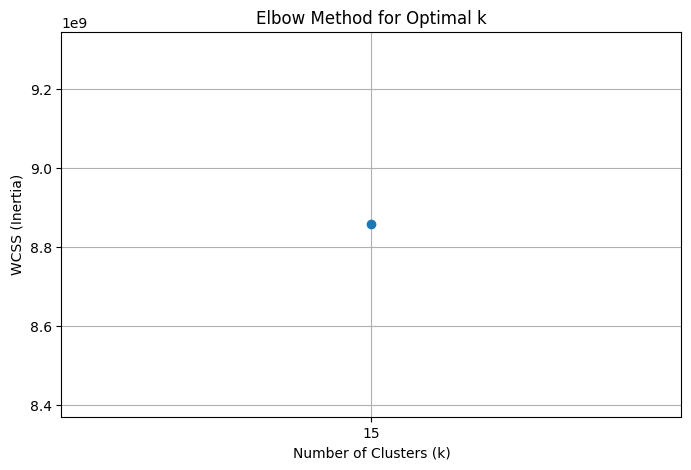

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Range of clusters to test
k_values = range(15, 16)

# List to store WCSS values
wcss = []

models={}

# Calculate WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(final_features_df)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS
    models[k]=kmeans
    print(k, wcss[-1])

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(k_values)
plt.grid()
plt.show()


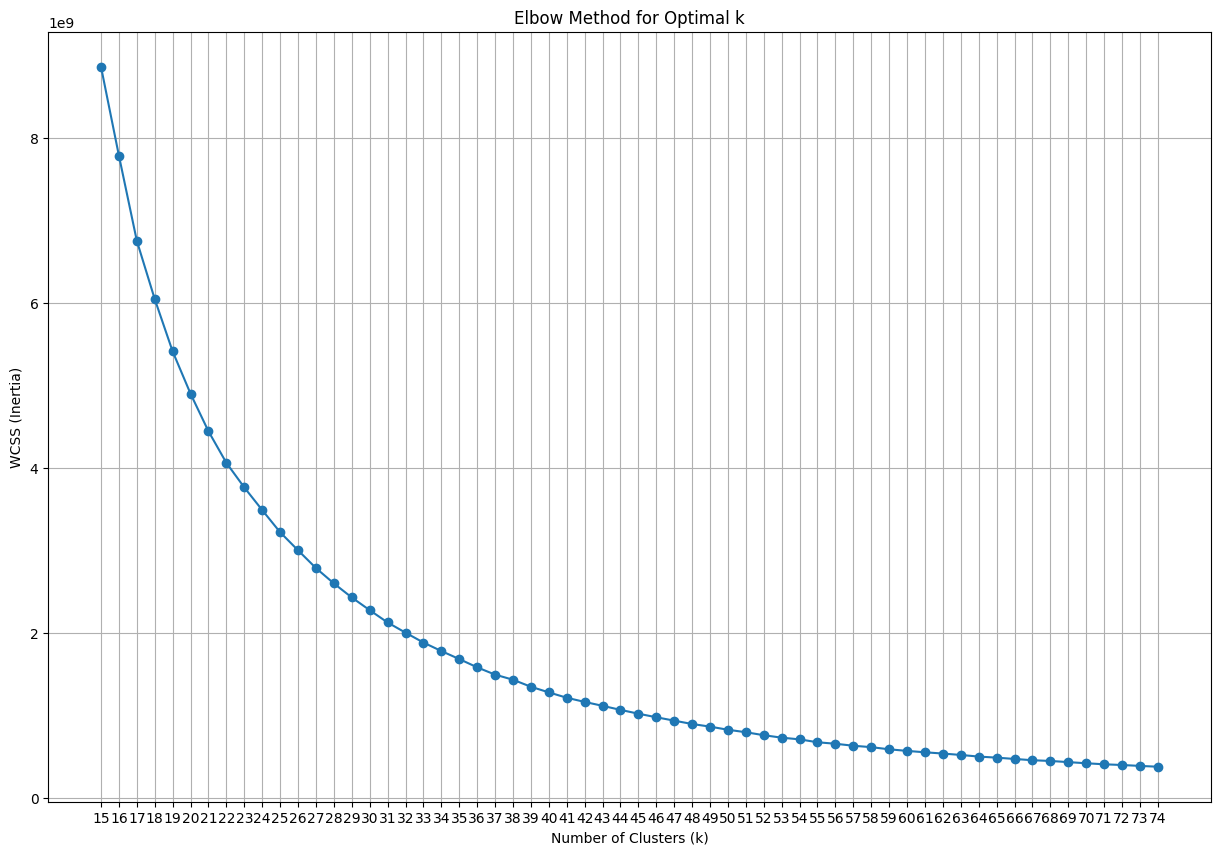

In [ ]:
# Plot the elbow graph
plt.figure(figsize=(15, 10))
plt.plot(k_values, wcss, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(k_values)
plt.grid()
plt.show()

In [24]:
kmeans_model=models[15]

In [25]:
import random
from sklearn.metrics.pairwise import cosine_similarity
def predict_articles(article, model, num_articles = 3):

    temp_tfidf_matrix = vectorizer_tf.transform([article["weighted_text"]])

    # Convert the TF-IDF matrix to a DataFrame for better visualization (optional)
    temp_tfidf_df = pd.DataFrame(temp_tfidf_matrix.toarray(), columns=vectorizer_tf.get_feature_names_out())

    temp_document = article["weighted_text"]

    temp_doc_term_matrix = vectorizer.transform([temp_document])

    temp_lda_features = lda_model.transform(temp_doc_term_matrix)

    temp_lda_features_df = pd.DataFrame(temp_lda_features, columns=[f'LDA-{i}' for i in range(lda_model.n_components)])

    temp_tfidf_ae = encoder.predict(temp_tfidf_matrix)

    temp_tfidf_svd = svd.transform(temp_tfidf_df)

    temp_tfidf_svd_scale = svd_scaler.transform(temp_tfidf_svd)

    temp_tfidf_ae_scale = ae_scaler.transform(temp_tfidf_ae)

    temp_added_ = temp_tfidf_svd_scale + temp_tfidf_ae_scale
    temp_tfidf_added_ = pd.DataFrame(temp_added_ , columns=["Tfid-"+str(i) for i in range(500)])

    temp_tfidf_added_['id'] = article["Index_Column"]
    temp_lda_features_df['id'] = article["Index_Column"]

    # Merging the LDA features with the TF-IDF features
    temp_final_features_df = pd.merge(temp_tfidf_added_, temp_lda_features_df, on='id', how='left')

    cll=kmeans_model.predict(temp_final_features_df)
    
    same_cluster_indices = [i for i, label in enumerate(kmeans_model.labels_) if label == cll]
    same_cluster_features = final_features_df.iloc[same_cluster_indices, :]
    similarities = cosine_similarity(temp_final_features_df, same_cluster_features)
    ranked_indices = similarities.argsort()[0][::-1]
    recommended_articles = [X_train.iloc[i,:] for i in ranked_indices[:num_articles]]
    recommended_articles_labels=[Y_train.iloc[i] for i in ranked_indices[:num_articles]]
    return recommended_articles,recommended_articles_labels
        


In [26]:
idx = random.sample(range(X_test.shape[0]), 1)[0]
print(Y_test.iloc[idx])
x,y=predict_articles(X_test.iloc[idx,:],"",5)

print(x)
print(y)

TRAVEL
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
[Unnamed: 0.1                                                             26688
link                         https://www.huffingtonpost.com/entry/cereal-te...
headline                     How To Make Tea That Tastes Like The Bottom Of...
short_description            Think you're too old and refined for sugary br...
authors                                                                    NaN
date                                                                2014-02-18
Index_Column                                                             26688
article_text                 There is a phenomenon that occurs when you eat...
cleaned_article_text         phenomenon occurs eat breakfast cereal often r...
cleaned_headline                  make tea taste like bottom cereal bowl photo
cleaned_short_description    think you are old refined sugary breakfast cer...
Unnamed: 0                                                                 NaN
weigh

## Code for Metrics

1) Adjusted Rand Index (ARI):

* Measures the similarity between predicted and true cluster assignments, adjusted for chance.
* Values range from -1 to 1; higher is better.

2) Normalized Mutual Information (NMI):

* Evaluates the amount of information shared between true and predicted labels.
* Values range from 0 to 1; higher is better.

3) Homogeneity, Completeness, and V-Measure:

* Homogeneity ensures clusters contain only points from the same class.
* Completeness ensures all points of a class are assigned to the same cluster.
* V-Measure is the harmonic mean of homogeneity and completeness.

In [27]:
### Evaluating the K Means clusters

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import LabelEncoder

unique_labels_KMeans = np.unique(kmeans_model.labels_)

cluster_labels = {}

for i in unique_labels_KMeans:
    print(f'Cluster {i}:')
    cluster_articles = Y_train[kmeans_model.labels_ == i]
    category_counts = cluster_articles.value_counts(normalize=True) * 100
    cluster_labels[f"Cluster {i}"] = category_counts.idxmax()
    print(category_counts)
    print("Cluster Label: "+cluster_labels[f"Cluster {i}"])
    print("------------------------------------------------------------------")


print("\n\nEvaluation Metrics:\n\n")

label_encoder = LabelEncoder()

predicted_labels = [cluster_labels[f"Cluster {i}"] for i in kmeans_model.labels_]

true_labels = list(Y_train)

all_labels = true_labels + predicted_labels
label_encoder.fit(all_labels)  # Fit on the combined true and predicted labels
true_labels = label_encoder.transform(true_labels)
predicted_labels = label_encoder.transform(predicted_labels)

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Homogeneity, Completeness, and V-Measure
homogeneity = homogeneity_score(true_labels, predicted_labels)
completeness = completeness_score(true_labels, predicted_labels)
v_measure = v_measure_score(true_labels, predicted_labels)

print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")
print(f"V-Measure: {v_measure:.4f}")




# for cluster in unique_labels_KMeans:

#     print(f"Cluster {cluster}:")

#     cluster_true_labels = list(Y_train[kmeans_model.labels_ == cluster])
#     cluster_pred_labels = [cluster_labels[f"Cluster {cluster}"] for i in range(len(cluster_true_labels))]

#     all_labels = cluster_true_labels + cluster_pred_labels
#     label_encoder.fit(all_labels)  # Fit on the combined true and predicted labels
#     cluster_true_labels = label_encoder.transform(cluster_true_labels)
#     cluster_pred_labels = label_encoder.transform(cluster_pred_labels)

#     print(cluster_true_labels)
#     print(cluster_pred_labels)

#     # Adjusted Rand Index (ARI)
#     ari = adjusted_rand_score(cluster_true_labels, cluster_pred_labels)
#     print(f"Adjusted Rand Index (ARI): {ari:.4f}")

#     # Normalized Mutual Information (NMI)
#     nmi = normalized_mutual_info_score(cluster_true_labels, cluster_pred_labels)
#     print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

#     # Homogeneity, Completeness, and V-Measure
#     homogeneity = homogeneity_score(cluster_true_labels, cluster_pred_labels)
#     completeness = completeness_score(cluster_true_labels, cluster_pred_labels)
#     v_measure = v_measure_score(cluster_true_labels, cluster_pred_labels)

#     print(f"Homogeneity: {homogeneity:.4f}")
#     print(f"Completeness: {completeness:.4f}")
#     print(f"V-Measure: {v_measure:.4f}")

#     print("------------------------------------------------------------------")
    

Cluster 0:
category
SPORTS            8.000000
STYLE & BEAUTY    7.672131
POLITICS          7.672131
TRAVEL            7.672131
QUEER VOICES      7.540984
FOOD & DRINK      7.213115
COMEDY            6.819672
HOME & LIVING     6.622951
WELLNESS          6.557377
ENTERTAINMENT     5.967213
PARENTS           5.901639
HEALTHY LIVING    5.770492
PARENTING         5.770492
BUSINESS          5.639344
BLACK VOICES      5.180328
Name: proportion, dtype: float64
Cluster Label: SPORTS
------------------------------------------------------------------
Cluster 1:
category
WELLNESS          7.767670
FOOD & DRINK      7.557733
PARENTS           7.137859
ENTERTAINMENT     7.067880
HEALTHY LIVING    6.927922
POLITICS          6.857943
TRAVEL            6.857943
SPORTS            6.787964
HOME & LIVING     6.578027
STYLE & BEAUTY    6.578027
COMEDY            6.438069
PARENTING         6.368090
BUSINESS          6.158153
BLACK VOICES      5.808258
QUEER VOICES      5.108467
Name: proportion, dtype: flo